In [2]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
data_path = os.path.join(os.getcwd(), '..', 'data', 'to_analyse')
dataset = load_files(data_path, shuffle=False)
print("n_samples: %d" % len(dataset.data))
print(dataset.target)
print(dataset.target_names)

n_samples: 4533
[0 0 0 ..., 1 1 1]
['hit', 'miss']


In [4]:
dataset.data = dataset.data[:5000]
dataset.target = dataset.target[:5000]
print("n_samples: %d" % len(dataset.data))

n_samples: 4533


In [4]:
dataset.data[0][:500]

b'Banishing trans fats from foods is linked to reductions in the number of heart attacks and cardiovascular deaths in the years after the bans are implemented, according to data from cities and counties in New York that have made the cut.\n\nAfter three years, the areas banning trans fats from eateries seemed to have an extra 6.2 percent reduction in heart attacks and strokes compared with those that didn\xe2\x80\x99t, researchers report in JAMA Cardiology. Last year, other researchers reported in the Journa'

In [5]:
# split the dataset in training and test set using a specific seed for reproducibility
docs_train, docs_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.25, random_state=80)

In [6]:
# Vectorise to extract features and filter out tokens that are too rare or too frequent
pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=3, max_df=0.95)),
    ('clf', LinearSVC(C=1000)),
])

In [7]:
# Use grid search to find out whether unigrams, bigrams, or tri-grams are more useful.
# Fit the pipeline on the training set using grid search for the parameters
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [8]:
# Print the mean and std for each candidate along with the parameter
# settings for all the candidates explored by grid search.
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'
             % (grid_search.cv_results_['params'][i],
                grid_search.cv_results_['mean_test_score'][i],
                grid_search.cv_results_['std_test_score'][i]))

0 params - {'vect__ngram_range': (1, 1)}; mean - 0.86; std - 0.01
1 params - {'vect__ngram_range': (1, 2)}; mean - 0.88; std - 0.00


In [9]:
# Predict the outcome on the testing set 
y_predicted = grid_search.predict(docs_test)

In [10]:
# How did the classifier perform?
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

             precision    recall  f1-score   support

        hit       0.60      0.17      0.26       154
       miss       0.89      0.98      0.94      1096

avg / total       0.86      0.88      0.85      1250



In [11]:
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[  26  128]
 [  17 1079]]


In [12]:
from sklearn.metrics import average_precision_score
y_score = grid_search.decision_function(docs_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.97


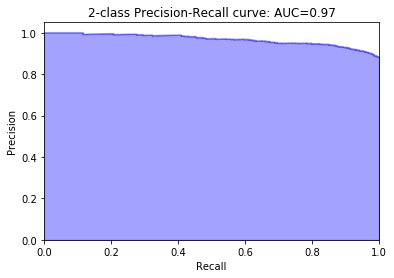

In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))
plt.show()

In [15]:
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function plot_learning_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_learning_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


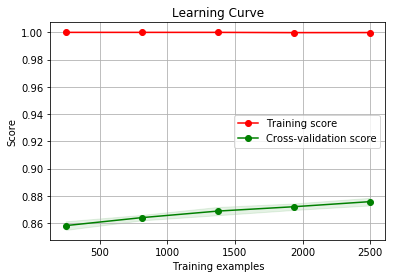

In [16]:
skplt.plot_learning_curve(grid_search, docs_train, y_train)
plt.show()

In [17]:
# Test some specific (new) examples
from newspaper import Article
import requests
url = 'https://deepmind.com/blog/cognitive-psychology/'
r = requests.get(url, verify=False) # False only because of local proxy issues.
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
hit1 = article.text
hit1[:100]

/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


'This is known as the ‘black-box’ problem, and it is becoming increasingly important as neural networ'

In [18]:
from newspaper import Article
import requests
url = 'https://deepmind.com/blog/cognitive-psychology/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
hit1 = article.text
url = 'https://theconversation.com/teaching-machines-to-understand-and-summarize-text-78236'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
hit2 = article.text
url = 'https://www.theguardian.com/football/2017/jul/07/chelsea-romelu-lukaku-offer-match-manchester-united'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss1 = article.text
url = 'https://arstechnica.com/business/2017/07/renewables-have-briefly-exceeded-nuclear-for-the-first-time-in-decades/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss2 = article.text

/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is be

In [19]:
url = 'https://arstechnica.com/tech-policy/2017/09/jury-finds-nintendo-wii-infringes-dallas-inventors-patent-awards-10m/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss3 = article.text

/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [20]:
docs_new = [hit1, hit2, miss1, miss2, miss3]
predicted = grid_search.predict(docs_new)
print(predicted)
for doc, category in zip(['hit1', 'hit2', 'miss1', 'miss2', 'miss3'], predicted):
     print('%r => %s' % (doc, dataset.target_names[category]))

[1 1 1 1 1]
'hit1' => miss
'hit2' => miss
'miss1' => miss
'miss2' => miss
'miss3' => miss


In [ ]:
grid_search.decision_function(docs_new)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.95, stop_words='english')),
    ('clf', BernoulliNB()),
])
pipeline.fit(docs_train, y_train)

In [ ]:
y_predicted = pipeline.predict(docs_test)
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

In [ ]:
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

In [ ]:
docs_new = [hit1, hit2, miss1, miss2, miss3]
predicted = pipeline.predict(docs_new)
print(predicted)
for doc, category in zip(['hit1', 'hit2', 'miss1', 'miss2', 'miss3'], predicted):
     print('%r => %s' % (doc, dataset.target_names[category]))

In [ ]:
pipeline.predict_proba(docs_new)